In [212]:
%matplotlib inline
import os
from itertools import chain

import matplotlib.pyplot as plt
from matplotlib import markers

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.externals import joblib

import h5py


# work_dir = '/home/ubuntu/workbench/MTLMusicRepresentation/'
fn = '../data/feature50/individual/conv_2d_self_50_0.0001_GTZAN_feature.h5'

hf = h5py.File(fn)

tsne = TSNE(n_components=2)
n_samples = hf['X'].shape[0] if hf['X'].shape[0] <= 3000 else 3000
rnd_idx = sorted(np.random.choice(hf['X'].shape[0],n_samples,replace=False))

x = tsne.fit_transform(hf['X'][rnd_idx])
y = hf['y'][:][rnd_idx]

k = 2 # top terms
m = 2 # top topics
n_cls = 12 # num cluster

# PLSA ============
topic_terms = pd.DataFrame.from_csv(
    '/mnt/msd/meta_data/plsa200topictags_name.csv'
).as_matrix()

# # BPM GMM ============
# topic_terms = joblib.load(
#     '/mnt/msd/meta_data/msd_tempo_gmm.dat.gz'
# )['means'].astype(int)


label_sets = {}
for cluster in set(l):
    cluster_idx = np.where(l==cluster)[0].tolist()
    all_terms = [hf['labels'][i] for i in y[cluster_idx]]
    unique_terms = set(all_terms)
    label_sets[cluster] = sorted(
        [(term,all_terms.count(term)) for term in unique_terms],
        key=lambda x:x[1]
    )[::-1]


In [ ]:
# cluster music un-supervised way
kms = KMeans(n_clusters=n_cls)
l = kms.fit_predict(hf['X'][rnd_idx])
# Z = hf['Z'].values()[0][rnd_idx] # need to fix
Z = hf['Z']['tag'][rnd_idx]

from sklearn.preprocessing import StandardScaler
sclr_z = StandardScaler()
Z = sclr_z.fit_transform(Z)

# collect top-k topic terms of the members of each cluster
topic_sets = {}
for cluster in set(l):
    cluster_idx = np.where(l==cluster)[0].tolist()
    cluster_terms = [[topic_terms[j,:k].tolist() for j in i]
                     for i in np.argsort(Z[cluster_idx],axis=1)[:,-m:]]
    all_terms = list(chain.from_iterable(chain.from_iterable(cluster_terms)))
    unique_terms = set(all_terms)
    topic_sets[cluster] = sorted(
        [(term,all_terms.count(term)) for term in unique_terms],
        key=lambda x:x[1]
    )[::-1]

NameError: name 'topic_sets' is not defined

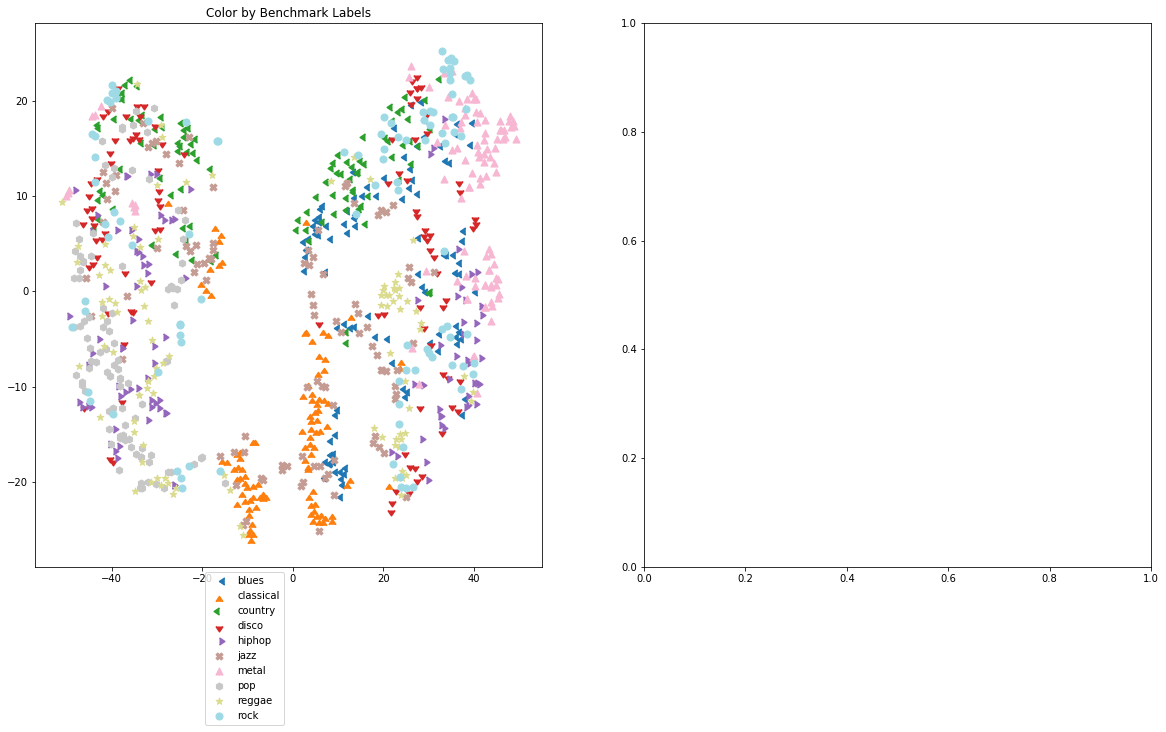

In [3]:
mks = list(markers.MarkerStyle.markers)
mks.remove('None')
mks.remove(None)
mks.remove(' ')
mks.remove('')
mks.remove('_')
mks.remove('|')
mks.remove(0)
mks.remove(1)
mks.remove(2)
mks.remove(3)
mks = mks[::2] * 5

unique = range(hf['labels'].shape[0])
colors = [plt.cm.Vega20(float(i)/max(unique)) for i in unique]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

for cls,marker in zip(unique,mks):
    label = hf['labels'][cls]
    cls_idx = np.where(y==cls)[0]
    ax1.scatter(x[cls_idx,0],x[cls_idx,1],s=50,
               c=colors[cls],alpha=1.,marker=marker,label=label)

ax1.set_title("Color by Benchmark Labels")
ax1.legend(loc='best', bbox_to_anchor=(0.5, 0))

unique = set(l)
colors = [plt.cm.Vega20(float(i)/max(unique)) for i in unique]

for cluster,marker in zip(unique,mks+mks):
    label = topic_sets[cluster][:5]
#     label = label_sets[cluster][:5]
    cluster_idx = np.where(l==cluster)[0].tolist()
    ax2.scatter(x[cluster_idx,0],x[cluster_idx,1],s=50,
               c=colors[cluster],alpha=1.,marker=marker,label=label)

ax2.set_title("Color by K-Means Cluster")
lgd = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0))

# fig.savefig('/home/ubuntu/workbench/End2EndMusic/GTZAN-TAG-PLSA-COMP.eps',
#             bbox_inches='tight',bbox_extra_artists=(lgd,),
#             format='eps')


In [4]:
model_list = {
    'tag':'/mnt/bulk2/models/conv_2d_tag_50_0.0001_param.npz',
    'bpm':'/mnt/bulk2/models/conv_2d_tempo_gmm_50_0.0001_param.npz',
    'pref':'/mnt/bulk2/models/conv_2d_pref_50_0.0001_param.npz',
    'lyrics':'/mnt/bulk2/models/conv_2d_lyrics_50_tfidf_0.0001_param.npz',
    'self':'/mnt/bulk2/models/conv_2d_self_50_0.0001_param.npz',
    'artist':'/mnt/bulk2/models/conv_2d_artist_50_0.0001_param.npz',
    'cdr_tag':'/mnt/bulk2/models/conv_2d_cdr_tag_50_0.0001_param.npz',
    'year':'/mnt/bulk2/models/conv_2d_year_50_0.0001_param.npz'
}

weight_map = {
    'conv1':'arr_8',
    'conv2':'arr_18',
    'conv31':'arr_28',
    'conv32':'arr_34',
    'conv41':'arr_44',
    'conv42':'arr_50',
    'conv51':'arr_60',
    'conv52':'arr_66',
    'conv53':'arr_72'
}

W = {}
for task, fn in model_list.iteritems():
    W[task] = {}
    with np.load(fn) as npf:
        for layer, ix in weight_map.iteritems():
            W[task][layer] = npf[ix]

In [270]:
# collect filters for each layer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# mdl = TSNE(n_components=2)
mdl = PCA(n_components=2)

# example
W1 = []
W1_l = []
for i, task in enumerate(model_list.keys()):
    if task == 'self':
        continue

    w = W[task]['conv42']
    ws = w.shape
    w_rsp = w.std(axis=(2,3))
#     w_rsp = w.reshape(ws[0]*ws[1], ws[2]*ws[3])
#     w_rsp = w.transpose(1,0,2,3)
#     w_rsp = w.reshape(ws[0], ws[1]*ws[2]*ws[3])
    
    if w_rsp.shape[0] > 150:
        w_rsp = w_rsp[np.random.choice(w_rsp.shape[0], 150, replace=False)]
        
    W1.append(w_rsp)
    W1_l.extend([i] * w_rsp.shape[0])

W1 = np.concatenate(W1,axis=0)
W1_l = np.array(W1_l)

w1 = mdl.fit_transform(W1)

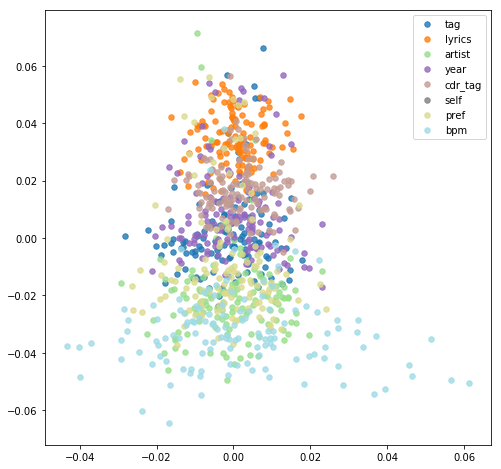

In [271]:
unique = range(len(model_list.keys()))
colors = [plt.cm.Vega20(float(i)/max(unique)) for i in unique]

fig, ax = plt.subplots(1,1,figsize=(8,8))

for i, task in enumerate(model_list.keys()):
    task_idx = np.where(W1_l==i)[0]
    ax.scatter(w1[task_idx,1],w1[task_idx,0], s=30,
               c=colors[i],alpha=0.8,label=task)
ax.legend()
